In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kerastuner as kt
from sklearn.model_selection import train_test_split
import seaborn as sns


def plot_curve(epochs, hist, list_of_metrics,name):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch "+name)
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()
    
    
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate,momentum,layers,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    #model.add(my_feature_layer)

    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=6,name='Output', activation = 'softmax'))                             
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=my_learning_rate,momentum=momentum),                                       
                loss=tf.keras.losses.MeanAbsoluteError(),
                metrics=my_metrics)
    return model


def train_model(model,x_data, y_data, epochs, label_name,
                batch_size=None,shuffle=True):
    #features = {name:np.array(value) for name, value in dataset.items()}
    history = model.fit(x=x_data, y=y_data, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle,validation_split=0.2,
                       #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])
                       )
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist
    
    
#returns dataframe
def test_model(model,x_data, y_data ,label_name):
    evaluation=model.evaluate(x = x_data, y = y_data, batch_size=batch_size)
    predicted = model.predict(x_data)
    df_test=pd.DataFrame(y_data,columns=[label_name])
   # print(predicted)
    df_predict=pd.DataFrame(predicted,columns=[label+"_pred" for label in label_name])
    return pd.concat([df_test,df_predict], axis=1)



<ipython-input-1-e65b5c7c3502>:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:

all_labels_features=["k6a1","k6a2","k11","k12","k9a1","k9a2","delta","lambda","overlap_s0_s2_k6a","overlap_s0_s2_k1","overlap_s0_s2_k9a"]
all_data=pd.read_csv("../../generated_Data/all_param_4_values_with_overlap.csv")
df_feature_labels=all_data[all_labels_features]

max_no_of_peak_list=max(all_data["no_of_max"])
print(max_no_of_peak_list)
df_feature_labels.head()

7


,k6a1,k6a2,k11,k12,k9a1,k9a2,delta,lambda,overlap_s0_s2_k6a,overlap_s0_s2_k1,overlap_s0_s2_k9a
0,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1000,0.6000,0.1000,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]","[0.7501, 0.2155, 0.031, 0.003, 0.0002]","[0.8102, 0.1704, 0.018, 0.0013, 0.0001]"
1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.0333,0.6000,0.2333,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]","[0.7501, 0.2155, 0.031, 0.003, 0.0002]","[0.9769, 0.0228, 0.0003, 0.0, 0.0]"
2,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1000,0.6000,0.2333,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]","[0.7501, 0.2155, 0.031, 0.003, 0.0002]","[0.8102, 0.1704, 0.018, 0.0013, 0.0001]"
3,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1000,0.5333,0.2333,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]","[0.7501, 0.2155, 0.031, 0.003, 0.0002]","[0.8102, 0.1704, 0.018, 0.0013, 0.0001]"
4,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1000,0.5333,0.1000,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]","[0.7501, 0.2155, 0.031, 0.003, 0.0002]","[0.8102, 0.1704, 0.018, 0.0013, 0.0001]"


In [3]:
overlap_s0_s2_k6a_array=np.asarray([  np.asarray([x for x in row.replace(",","").replace("[","").replace("]","").replace("  "," ",5).replace(" ",";").split(";") if x!=""],dtype=np.float64)     for row in df_feature_labels["overlap_s0_s2_k6a"] ])

overlap_s0_s2_k1_array=np.asarray([  np.asarray([x for x in row.replace(",","").replace("[","").replace("]","").replace("  "," ",5).replace(" ",";").split(";") if x!=""],dtype=np.float64)     for row in df_feature_labels["overlap_s0_s2_k1"] ])

overlap_s0_s2_k9a_array=np.asarray([  np.asarray([x for x in row.replace(",","").replace("[","").replace("]","").replace("  "," ",5).replace(" ",";").split(";") if x!=""],dtype=np.float64)     for row in df_feature_labels["overlap_s0_s2_k9a"] ])


concat_feature=np.concatenate((overlap_s0_s2_k6a_array,overlap_s0_s2_k1_array,overlap_s0_s2_k9a_array),axis=1)
omega_array=np.zeros((len(concat_feature),3))
#w6a
omega_array[:][0]=0.0740/27.211
#w1
omega_array[:][1]=0.1273/27.211
#w9a
omega_array[:][2]=0.1568/27.211

print(omega_array.shape)
print(concat_feature.shape)
concat_feature=np.concatenate((concat_feature,omega_array),axis=1)


concat_label=df_feature_labels[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].abs().to_numpy()#,"delta","lambda"


x_train_overlap, x_test_overlap,y_train_overlap,y_test_overlap = train_test_split( concat_feature, concat_label  ,test_size=0.20, random_state=42)

print(x_train_overlap)

(65464, 3)
(65464, 15)
[[0.5232 0.3386 0.1098 ... 0.     0.     0.    ]
 [0.9307 0.0669 0.0024 ... 0.     0.     0.    ]
 [0.9307 0.0669 0.0024 ... 0.     0.     0.    ]
 ...
 [0.5232 0.3386 0.1098 ... 0.     0.     0.    ]
 [0.5232 0.3386 0.1098 ... 0.     0.     0.    ]
 [0.9307 0.0669 0.0024 ... 0.     0.     0.    ]]


In [4]:
learning_rate = 1e-2
momentum=0.3
epochs = 50
batch_size = 150

#specify the classification threshold
classification_threshold = 0.15

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.MeanAbsoluteError()]
layers=[16,256,2048,512,64,16]


all_label_list=["k6a1","k6a2","k11","k12","k9a1","k9a2"]#,"delta","lambda"]

my_model= create_model2(learning_rate,momentum,layers,metric,my_act_function="relu")

epochs_run, hist = train_model(my_model,x_train_overlap, y_train_overlap, epochs, 
                          all_label_list, batch_size)


Epoch 1/50
280/280 [==============================] - 6s 19ms/step - loss: 0.1000 - mean_absolute_error: 0.1000 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001
Epoch 2/50
280/280 [==============================] - 4s 16ms/step - loss: 0.1000 - mean_absolute_error: 0.1000 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001
Epoch 3/50
280/280 [==============================] - 4s 14ms/step - loss: 0.1001 - mean_absolute_error: 0.1001 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001
Epoch 4/50
280/280 [==============================] - 5s 17ms/step - loss: 0.1000 - mean_absolute_error: 0.1000 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001
Epoch 5/50
280/280 [==============================] - 4s 16ms/step - loss: 0.1000 - mean_absolute_error: 0.1000 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001
Epoch 6/50
280/280 [==============================] - 4s 16ms/step - loss: 0.0998 - mean_absolute_error: 0.0998 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001
Epoch 7/50

280/280 [==============================] - 4s 15ms/step - loss: 0.1000 - mean_absolute_error: 0.1000 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001


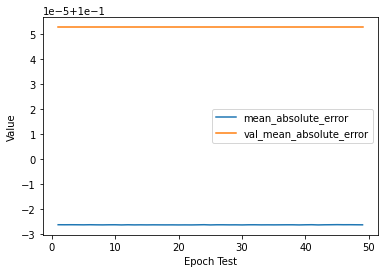

In [5]:
list_of_metrics_to_plot = ['mean_absolute_error',"val_mean_absolute_error"] 
plot_curve(epochs_run, hist, list_of_metrics_to_plot,"Test")

In [6]:
#print(y_test_overlap)
delta_test_result=test_model(my_model,x_test_overlap,y_test_overlap,all_label_list)



delta_test_result.round(3).head(50)

88/88 [==============================] - 1s 6ms/step - loss: 0.1002 - mean_absolute_error: 0.1002


,"(k6a1,)","(k6a2,)","(k11,)","(k12,)","(k9a1,)","(k9a2,)",k6a1_pred,k6a2_pred,k11_pred,k12_pred,k9a1_pred,k9a2_pred
0,0.033,0.033,0.100,0.100,0.033,0.033,0.167,0.168,0.166,0.172,0.161,0.167
1,0.033,0.033,0.033,0.100,0.100,0.033,0.167,0.168,0.166,0.172,0.161,0.167
2,0.100,0.033,0.033,0.033,0.100,0.033,0.167,0.168,0.165,0.172,0.161,0.166
3,0.033,0.033,0.033,0.033,0.100,0.033,0.167,0.168,0.165,0.172,0.161,0.166
4,0.033,0.033,0.100,0.033,0.033,0.033,0.167,0.168,0.165,0.172,0.161,0.166
5,0.033,0.033,0.033,0.100,0.100,0.100,0.166,0.168,0.165,0.171,0.162,0.167
6,0.100,0.100,0.033,0.033,0.033,0.033,0.167,0.168,0.165,0.172,0.161,0.167
7,0.100,0.033,0.100,0.100,0.033,0.100,0.166,0.168,0.165,0.171,0.162,0.167
8,0.033,0.033,0.100,0.100,0.100,0.100,0.166,0.168,0.165,0.171,0.162,0.167
9,0.033,0.033,0.100,0.100,0.100,0.033,0.167,0.168,0.166,0.172,0.161,0.167
